In [19]:
import os
import time
from matplotlib import pyplot as plt
import cv2
import requests
from PIL import Image
from pathlib import Path

from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta import Thread
from openai.types.beta import Assistant


load_dotenv()


# Create the AOAI client to use for the proxy agent.
assistant_client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  # Your API key for the assistant api model
    api_version=os.getenv("GPT4_AZURE_OPENAI_API_VERSION"),  # API version  (i.e. 2024-02-15-preview)
    azure_endpoint=os.getenv(
        "AZURE_OPENAI_ENDPOINT"
    ),  # Your Azure endpoint (i.e. "https://YOURENDPOINT.openai.azure.com/")
)
# Assistant model should be '1106' or higher
assistant_deployment_name = os.getenv(
    "GPT4_DEPLOYMENT_NAME"
)  # The name of your assistant model deployment in Azure OpenAI (i.e. "GPT4Assistant")

# name of the model deployment for DALL·E 3
dalle_client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version=os.getenv("DALLE3_AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
)
dalle_deployment_name = os.getenv("DALLE3_DEPLOYMENT_NAME")

# name of the model deployment for GPT 4 with Vision
vision_client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
)
vision_deployment_name = os.getenv("GPT4VISION_DEPLOYMENT_NAME")

In [3]:
name_dl = "dalle_assistant"
instructions_dl = """As a premier AI specializing in image generation, you possess the expertise to craft precise visuals based on given prompts. It is essential that you diligently generate the requested image, ensuring its accuracy and alignment with the user's specifications, prior to delivering a response."""
tools = [
    {
        "type": "function",
        "function": {
            "name": "generate_image",
            "description": "Creates and displays an image",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {
                        "type": "string",
                        "description": "The prompt to be used to create the image",
                    }
                },
                "required": ["prompt"],
            },
        },
    }
]

verbose_output = True

In [4]:
dalle_assistant = assistant_client.beta.assistants.create(
    name=name_dl, instructions=instructions_dl, model=assistant_deployment_name, tools=tools
)

In [5]:
def generate_image(prompt: str) -> str:
    """
    Call the Azure OpenAI Dall-e 3 model to generate an image from a text prompt.
    Executes the call to the Azure OpenAI Dall-e 3 image creator, saves the file into the local directory, and displays the image.
    """

    print("Dalle Assistant Message: Creating the image ...")

    response = dalle_client.images.generate(
        model=dalle_deployment_name, prompt=prompt, size="1024x1024", quality="standard", n=1
    )

    # Retrieve the image URL from the response (assuming response structure)
    image_url = response.data[0].url

    # Open the image from the URL and save it to a temporary file.
    im = Image.open(requests.get(image_url, stream=True).raw)

    # Define the filename and path where the image should be saved.
    filename = "temp.jpg"
    local_path = Path(filename)

    # Save the image.
    im.save(local_path)

    # Get the absolute path of the saved image.
    full_path = str(local_path.absolute())

    img = cv2.imread("temp.jpg", cv2.IMREAD_UNCHANGED)

    # Convert the image from BGR to RGB for displaying with matplotlib,
    # because OpenCV uses BGR by default and matplotlib expects RGB.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib.
    plt.imshow(img_rgb)
    plt.axis("off")  # Turn off axis labels.
    plt.show()

    # Return the full path of the saved image.
    print("Dalle Assistant Message: " + full_path)
    return "Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant"

In [7]:
name_vs = "vision_assistant"
instructions_vs = """As a leading AI expert in image analysis, you excel at scrutinizing and offering critiques to refine and improve images. Your task is to thoroughly analyze an image, ensuring that all essential assessments are completed with precision before you provide feedback to the user. You have access to the local file system where the image is stored."""
tools = [
    {
        "type": "function",
        "function": {
            "name": "analyze_image",
            "description": "analyzes and critics an image",
            "parameters": {"type": "object", "properties": {}, "required": []},
        },
    }
]

verbose_output = True

In [8]:
vision_assistant = assistant_client.beta.assistants.create(
    name=name_vs, instructions=instructions_vs, model=assistant_deployment_name, tools=tools
)

In [14]:
def analyze_image() -> str:
    """
    Call the Azure OpenAI GPT4 Vision model to analyze and critic an image and return the result.The resulting output should be a new prompt for dall-e that enhances the image based on the criticism and analysis
    """
    print("Vision Assistant Message: " + "Analyzing the image...")

    import base64
    from pathlib import Path

    # Create a Path object for the image file
    image_path = Path("temp.jpg")

    # Using a context manager to open the file with Path.open()
    with image_path.open("rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    content_images = [
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
        for base64_image in [base64_image]
    ]
    response = vision_client.chat.completions.create(
        model=vision_deployment_name,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Analyze and critic this image and generate a new enhanced prompt for Dall-e with the criticism and analysis.",
                    },
                    *content_images,
                ],
            }
        ],
        max_tokens=1000,
    )
    print("Vision Assistant Message: " + response.choices[0].message.content)
    return response.choices[0].message.content

In [9]:
name_pa = "user_proxy"
agent_arr = ["dalle_assistant", "vision_assistant"]
agent_string = ""
for item in agent_arr:
    agent_string += f"{item}\n"

instructions_pa = f"""As a user proxy agent, your primary function is to streamline dialogue between the user and the specialized agents within this group chat. You are tasked with articulating user inquiries with clarity to the relevant agents and maintaining a steady flow of communication to guarantee the user's request is comprehensively addressed. Please withhold your response to the user until the task is completed, unless an issue is flagged by the respective agent or when you can provide a conclusive reply.

You have access to the local file system where files are stores. For example, you can access the image generated by the Dall-e assistant and send it to the Vision assistant for analysis.

You have access to the following agents to accomplish the task:
{agent_string}
If the agents above are not enough or are out of scope to complete the task, then run send_message with the name of the agent.

When outputting the agent names, use them as the basis of the agent_name in the send message function, even if the agent doesn't exist yet.

Run the send_message function for each agent name generated. 

Do not ask for followup questions, run the send_message function according to your initial input.

Plan:
1. dalle_assistant creates image 
2. vision_assistant analyzes images and creates a new prompt for dalle_assistant
3. dalle_assistant creates a new image based on the new prompt
4. vision_assistant analyzes images and creates a new prompt for dalle_assistant
5. dalle_assistant creates a new image based on the new prompt

Now take a deep breath and accomplish the plan above. Always follow the plan step by step in the exact order and do not ask for followup questions. Do not skip any steps in the plan, do not repeat any steps and always complete the entire plan in order step by step.  
The dall-e assistant can never run more than one time in a row, review your plan before running the next step.
"""

tools = [
    {"type": "code_interpreter"},
    {
        "type": "function",
        "function": {
            "name": "send_message",
            "description": "Send messages to other agents in this group chat.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The message to be sent",
                    },
                    "agent_name": {
                        "type": "string",
                        "description": "The name of the agent to execute the task.",
                    },
                },
                "required": ["query", "agent_name"],
            },
        },
    },
]

verbose_output = True

In [10]:
user_proxy = assistant_client.beta.assistants.create(
    name=name_pa, instructions=instructions_pa, model=assistant_deployment_name, tools=tools
)

In [11]:
from typing import Dict, Optional

agents_threads: Dict[str, Dict[str, Optional[str]]] = {
    "dalle_assistant": {"agent": dalle_assistant, "thread": None},
    "vision_assistant": {"agent": vision_assistant, "thread": None},
}


# Define the send_message function with only the query parameter
def send_message(query: str, agent_name: str) -> str:
    # Check if the agent_name is in agents_threads
    if agent_name not in agent_arr:
        print(
            f"Agent '{agent_name}' does not exist. This means that the multi-agent system does not have the necessary agent to execute the task. *** FUTURE CODE: AGENT SWARM***"
        )
        # return None
    # If the program has not exited, proceed with setting the agent recipient
    recipient_type = agent_name
    recipient_info = agents_threads[recipient_type]

    # If the program has not exited, proceed with setting the agent recipient
    recipient_type = agent_name
    recipient_info = agents_threads[recipient_type]

    # Create a new thread if user proxy and agent thread does not exist
    if not recipient_info["thread"]:
        thread_object = assistant_client.beta.threads.create()
        recipient_info["thread"] = thread_object

    # This function dispatches a message to the proper agent and it's thread
    return dispatch_message(query, recipient_info["agent"], recipient_info["thread"])
    # print("Proxy Assistant Message: " + message)

In [12]:
import json


def dispatch_message(message: str, agent: Assistant, thread: Thread) -> str:
    # Loops through all the agents functions to determine which function to use

    available_functions = {}
    # Iterate through each tool in the agent.tools list
    for tool in agent.tools:
        # Check if the tool has a 'function' attribute
        if hasattr(tool, "function"):
            function_name = tool.function.name
            # Attempt to retrieve the function by its name and add it to the available_functions dictionary
            if function_name in globals():
                available_functions[function_name] = globals()[function_name]
        else:
            # Handle the case where the tool does not have a 'function' attribute
            print("This tool does not have a 'function' attribute.")
    # Draft a new message as part of the ongoing conversation.
    message = assistant_client.beta.threads.messages.create(thread_id=thread.id, role="user", content=message)
    # Carry out the tasks delineated in this discussion thread.
    run = assistant_client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=agent.id,
    )
    while True:
        # Await the completion of the thread execution.
        while run.status in ["queued", "in_progress"]:
            run = assistant_client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
            time.sleep(1)

        # If an action is necessary, initiate the appropriate function to perform the task.
        if run.status == "requires_action":
            tool_calls = run.required_action.submit_tool_outputs.tool_calls
            for _tool_call in tool_calls:
                tool_responses = []
                if (
                    run.required_action.type == "submit_tool_outputs"
                    and run.required_action.submit_tool_outputs.tool_calls is not None
                ):
                    tool_calls = run.required_action.submit_tool_outputs.tool_calls
                    for call in tool_calls:
                        if call.type == "function":
                            if call.function.name not in available_functions:
                                raise Exception("Function requested by the model does not exist")

                            # Assign the appropriate function to the agent for invocation.
                            function_to_call = available_functions[call.function.name]
                            tool_response = function_to_call(**json.loads(call.function.arguments))
                            tool_responses.append({"tool_call_id": call.id, "output": tool_response})

            # Present the outcomes produced by the tool.
            run = assistant_client.beta.threads.runs.submit_tool_outputs(
                thread_id=thread.id, run_id=run.id, tool_outputs=tool_responses
            )

        # if the run is completed, return the assistant message else provide error
        elif run.status == "failed":
            raise Exception("Run Failed. ", run.last_error)
        # Craft a reply from the assistant.
        else:
            messages = assistant_client.beta.threads.messages.list(thread_id=thread.id)

            # Transmit the response message back to the facilitating agent.
            return messages.data[0].content[0].text.value

This tool does not have a 'function' attribute.
Dalle Assistant Message: Creating the image ...


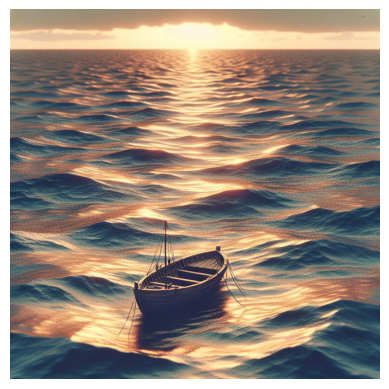

Dalle Assistant Message: c:\Users\vaalt\OneDrive\Desktop\Projects\github\GenAI-Demos\Assistant APIs\temp.jpg
Vision Assistant Message: Analyzing the image...
Vision Assistant Message: Criticism:
1. The image seems to have an unrealistic appearance, especially with the way the light reflects on the water, which appears too smooth and uniform.
2. The boat's shadows and highlights don't match the direction of the light source, creating an inconsistent lighting scenario.
3. The water texture is a bit repetitive and lacks some of the natural chaos and randomness you would expect in waves.
4. The horizon line could be more defined to create a better sense of depth and distance.

Analysis:
1. The color palette is warm and inviting, which gives the image a calming and tranquil feeling.
2. The composition with the boat as the focal point works well, drawing the viewer's eye to the center of the image.
3. The sun's position just above the horizon suggests either sunrise or sunset, which are usua

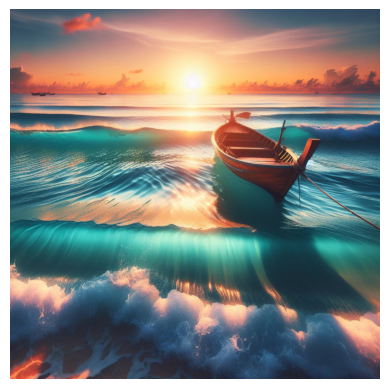

Dalle Assistant Message: c:\Users\vaalt\OneDrive\Desktop\Projects\github\GenAI-Demos\Assistant APIs\temp.jpg
Vision Assistant Message: Analyzing the image...
Vision Assistant Message: Analysis:
The image depicts a serene, early-morning scene on a tropical beach with a wooden boat gently rocking on calm waves under a beautiful sunrise. The color palette of warm oranges, blues, and cyans creates a peaceful and inviting atmosphere. The sun's light is reflected on the water, giving it a sparkling, almost ethereal look. The composition is balanced, with the boat positioned off-center, allowing the viewer's eye to wander through the image.

Criticism:
While the image is stunning, it feels somewhat unrealistic. The waves appear too perfect and uniform, as if digitally manipulated. The sun's position directly behind the boat can be seen as cliché and overdone. Additionally, the image's luminance could be criticized for being excessively heightened, which may detract from the authenticity of a 

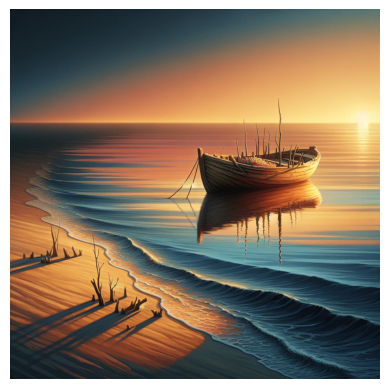

Dalle Assistant Message: c:\Users\vaalt\OneDrive\Desktop\Projects\github\GenAI-Demos\Assistant APIs\temp.jpg


In [20]:
thread = assistant_client.beta.threads.create()

# Initiate proxy agent and the main thread. This thread will remain active until the task is completed and will serve as the main communication thread between the other agents.
user_message = input("User Query: ")
message = dispatch_message(user_message, user_proxy, thread)

In [39]:
assistant_client.beta.threads.messages.list(thread_id = thread.id).data[0].content[0].text.value

"The task is now completed. We have successfully generated an image of a boat at a secluded beach at sunrise, enhancing it through rounds of analysis and modifications to achieve realistic and appealing results. The final image captures the peaceful atmosphere of a sunrise with a wooden boat anchored amidst rolling waves. With a color palette reflecting authentic sunrise hues and a composition that guides the viewer's eye across the scene, the image is ready for viewing, downloading, or any other form of utilization."

In [56]:
agents_threads['vision_assistant']['thread'].id

'thread_J85Isw8deYC59SQv6aTDhUum'

In [55]:
vision_assistant

Assistant(id='asst_KnarYPcUsKDbB1bIjMiZ1c5n', created_at=1711216137, description=None, file_ids=[], instructions='As a leading AI expert in image analysis, you excel at scrutinizing and offering critiques to refine and improve images. Your task is to thoroughly analyze an image, ensuring that all essential assessments are completed with precision before you provide feedback to the user. You have access to the local file system where the image is stored.', metadata={}, model='gpt-4', name='vision_assistant', object='assistant', tools=[FunctionTool(function=FunctionDefinition(name='analyze_image', description='analyzes and critics an image', parameters={'type': 'object', 'properties': {}, 'required': []}), type='function')])

In [57]:
assistant_client.beta.threads.messages.list(thread_id = agents_threads['vision_assistant']['thread'].id).data[0].content[0].text.value

"Based on the analysis, here are some recommendations and feedback:\n\nCriticism:\n\n1. Despite being a visually appealing image, it seems to lean slightly to the side of unrealism. The waves come across as excessively perfect and uniform, indicating potential digital manipulation.\n   \n2. The direct positioning of the sun right behind the boat is a composition technique that is often considered cliché and overdone. This could perhaps be repositioned for a more unique perspective.\n   \n3. The luminance in the image seems over-accentuated, which might take away from the true appeal and authenticity of a natural sunrise.\n\nAnalysis:\n\n1. The image presents a tranquil scene of a beach at dawn, with a wooden boat aptly situated on calm, gentle waves. This is sure to evoke a sense of serene calmness in the viewer.\n   \n2. The color palette fuses warm hues of oranges, blues, and cyans, cultivating a serene and welcoming atmosphere, enhanced by the light of the rising sun reflecting on t

# TEST

In [8]:
import os
import time
from matplotlib import pyplot as plt
import cv2
import requests
from PIL import Image
from pathlib import Path

from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta import Thread
from openai.types.beta import Assistant


load_dotenv()


# Create the AOAI client to use for the proxy agent.
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  # Your API key for the assistant api model
    api_version=os.getenv("GPT4_AZURE_OPENAI_API_VERSION"),  # API version  (i.e. 2024-02-15-preview)
    azure_endpoint=os.getenv(
        "AZURE_OPENAI_ENDPOINT"
    ),  # Your Azure endpoint (i.e. "https://YOURENDPOINT.openai.azure.com/")
)
# Assistant model should be '1106' or higher
assistant_deployment_name = os.getenv(
    "GPT4_DEPLOYMENT_NAME"
)  # The name of your assistant model deployment in Azure OpenAI (i.e. "GPT4Assistant")

# name of the model deployment for DALL·E 3
dalle_client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version=os.getenv("DALLE3_AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
)
dalle_deployment_name = os.getenv("DALLE3_DEPLOYMENT_NAME")

# name of the model deployment for GPT 4 with Vision
vision_client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
)
vision_deployment_name = os.getenv("GPT4VISION_DEPLOYMENT_NAME")

## Function

In [9]:
import time
import yfinance as yf


def get_stock_price(symbol: str) -> float:
    stock = yf.Ticker(symbol)
    price = stock.history(period="1d")['Close'].iloc[-1]
    return price

## Tools

In [6]:
tools_list = [{
    "type": "function",
    "function": {

        "name": "get_stock_price",
        "description": "Retrieve the latest closing price of a stock using its ticker symbol",
        "parameters": {
            "type": "object",
            "properties": {
                "symbol": {
                    "type": "string",
                    "description": "The ticker symbol of the stock"
                }
            },
            "required": ["symbol"]
        }
    }
}]

## Assistant

In [14]:
assistant = client.beta.assistants.create(
    name="Data Analytst Assistant",
    instructions="You are a personal Data Analyst Assistant", 
    model=assistant_deployment_name, 
    tools=tools_list
)

In [16]:
# Step 2: Create a Thread
thread = client.beta.threads.create()

# Step 3: Add a Message to a Thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Can you please provide me stock price of Apple?"
)

# Step 4: Run the Assistant
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
    instructions="Please address the user as Mervin Praison."
)

In [30]:
thread.id

'thread_SziUDbxzzkR1ess0XTox4ZEf'

In [17]:
print(run.model_dump_json(indent=4))

{
    "id": "run_5R8BVqwa478PAEAz50LNtwC0",
    "assistant_id": "asst_bF9qB60Hf2bF0XedcSLrWvzl",
    "cancelled_at": null,
    "completed_at": null,
    "created_at": 1711626583,
    "expires_at": 1711627183,
    "failed_at": null,
    "file_ids": [],
    "instructions": "Please address the user as Mervin Praison.",
    "last_error": null,
    "metadata": {},
    "model": "gpt-4",
    "object": "thread.run",
    "required_action": null,
    "started_at": null,
    "status": "queued",
    "thread_id": "thread_SziUDbxzzkR1ess0XTox4ZEf",
    "tools": [
        {
            "function": {
                "name": "get_stock_price",
                "description": "Retrieve the latest closing price of a stock using its ticker symbol",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "symbol": {
                            "type": "string",
                            "description": "The ticker symbol of the stock

## get weather

In [72]:
tools_list = [
{"type": "function",
"function": {
        "name": "get_weather",
        "description": "Determine weather in a certain location",
        "parameters": {
            "type": "object",
            "properties": {
            "location": {
                "type": "string",
                "description": "The city and country e.g. Paris (France)"
                }
            },
            "required": [
                "location"
            ]
        }
    }
}
]

In [79]:
assistant = client.beta.assistants.create(
    name="AI Assistant",
    instructions="You are a personal AI Assistant", 
    model="gpt-4-turbo", 
    tools=tools_list
)

# Step 2: Create a Thread
thread = client.beta.threads.create()

# Step 3: Add a Message to a Thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="What is the current weather in Milan?"
)

# Step 4: Run the Assistant
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
    instructions="Please address the user as Valentina."
)

In [67]:
import json

json_output = run.json()
data = json.loads(json_output)

for key, value in data.items():
    print(f"{key}: {value}")


id: run_zfRTZMsSRaWHY78bnwBO8NjX
assistant_id: asst_iLa8HAhgddX99aKLJJAwto5u
cancelled_at: None
completed_at: None
created_at: 1711719541
expires_at: 1711720141
failed_at: None
file_ids: []
instructions: Please address the user as Valentina.
last_error: None
metadata: {}
model: gpt-4-turbo
object: thread.run
required_action: None
started_at: None
status: queued
thread_id: thread_yVPsV1GetYeAHJSnGN7ah4B0
tools: [{'function': {'name': 'get_weather', 'description': 'Determine weather in a certain location', 'parameters': {'type': 'object', 'properties': {'location': {'type': 'string', 'description': 'The city and country e.g. Paris (France)'}}, 'required': ['location']}}, 'type': 'function'}]
usage: None


In [58]:
assistant.id

'asst_Ff8lcQP3zyRZfWS3vACwNyDR'

In [56]:
def get_weather(location):
    base_url = "https://api.openweathermap.org/data/2.5/weather?"

    complete_url = base_url + "q=" + location + "&appid=" + api_key + "&units=metric" #set your api key here
    
    response = requests.get(complete_url)
    weather_condition = response.json()["weather"][0]["description"]
    temperature = response.json()["main"]["temp"]
    
    return f"""Here is some information about the weather in {location}:\n
        - The weather is: {weather_condition}.\n
        - The temperature is: {temperature} degrees Celsius.\n
    """

In [82]:
while True:
    # Wait for 5 seconds
    time.sleep(5)

    # Retrieve the run status
    run_status = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id
    )
    print(run_status.model_dump_json(indent=4))

    # If run is completed, get messages
    if run_status.status == 'completed':
        messages = client.beta.threads.messages.list(
            thread_id=thread.id
        )

        # Loop through messages and print content based on role
        for msg in messages.data:
            role = msg.role
            content = msg.content[0].text.value
            print(f"{role.capitalize()}: {content}")

        break
    elif run_status.status == 'requires_action':
        print("Function Calling")
        required_actions = run_status.required_action.submit_tool_outputs.model_dump()
        print(required_actions)
        tool_outputs = []
        import json
        for action in required_actions["tool_calls"]:
            func_name = action['function']['name']
            arguments = json.loads(action['function']['arguments'])           
            output = globals()[func_name](**arguments)  # Assuming functions are in the global scope
            tool_outputs.append({
                "tool_call_id": action['id'],
                "output": output
            })
            
        print("Submitting outputs back to the Assistant...")
        client.beta.threads.runs.submit_tool_outputs(
            thread_id=thread.id,
            run_id=run.id,
            tool_outputs=tool_outputs
        )
    else:
        print("Waiting for the Assistant to process...")
        time.sleep(5)

{
    "id": "run_Rys3l7zd7uR94pRx64ETPu8s",
    "assistant_id": "asst_QTz55diqssQmJrvmHxCbe9Y6",
    "cancelled_at": null,
    "completed_at": null,
    "created_at": 1711882075,
    "expires_at": 1711882675,
    "failed_at": null,
    "file_ids": [],
    "instructions": "Please address the user as Valentina.",
    "last_error": null,
    "metadata": {},
    "model": "gpt-4-turbo",
    "object": "thread.run",
    "required_action": {
        "submit_tool_outputs": {
            "tool_calls": [
                {
                    "id": "call_KoKKad9YKkHdqhMut2kh0peX",
                    "function": {
                        "arguments": "{\"location\":\"Milan, Italy\"}",
                        "name": "get_weather"
                    },
                    "type": "function"
                }
            ]
        },
        "type": "submit_tool_outputs"
    },
    "started_at": 1711882076,
    "status": "requires_action",
    "thread_id": "thread_TSFeZyzOPZaH9PEmxu65qFpO",
    "to

In [78]:
client.beta.threads.delete(thread_id = thread.id)

ThreadDeleted(id='thread_Bf4k39NALhPRPlbF4tiAs8dF', deleted=True, object='thread.deleted')